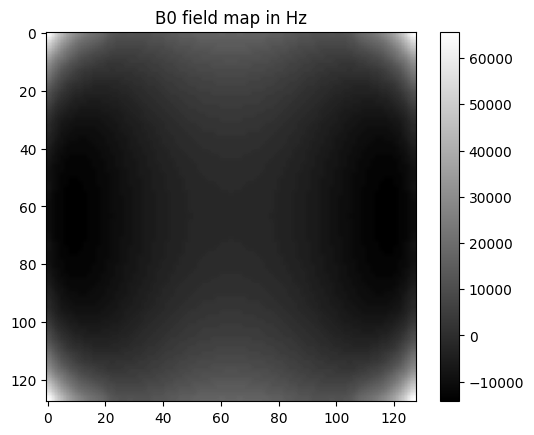

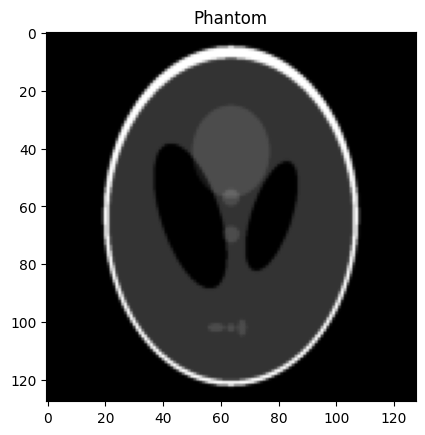

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.fft import fftshift, fft2, ifft2
from skimage.data import shepp_logan_phantom
from skimage.transform import resize
import pandas as pd
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import lsqr
from tqdm import tqdm

# Re-generate and resize Shepp-Logan phantom
phantom = shepp_logan_phantom()
phantom = resize(phantom, (128, 128))
#phantom /= np.max(phantom)
phantom = phantom.astype(dtype=np.complex128) # Make the phantom complex

N_spins = 128  # Number of spins in the phantom
# # Phantom is a 2D delta function (single point in the center)
# phantom = np.zeros((N_spins, N_spins), dtype=np.complex128)  
# phantom[N_spins//2, N_spins//2] = 1

# Load the B0 field map from the csv file
B0_field_map = pd.read_csv('2Dslice.csv', header=None).values
gamma = 42.58e6  # Gyromagnetic ratio for hydrogen in Hz/T
B0_field_map  = (B0_field_map * gamma)/(2*np.pi * 10000)  # Convert to Hz/T
B0_mean = np.mean(B0_field_map)  # Mean value of the B0 field map
B0_field_map -= B0_mean # subtract by the mean value of the B0 field map
B0_field_map *= 20 # B0 multiplier to see the distortion better
B0_field_map = resize(B0_field_map, (128, 128))

B0_test = np.ones((N_spins, N_spins), dtype=np.complex128)

B0_using = B0_field_map

# Plot the B0 field map
plt.title('B0 field map in Hz')
plt.imshow(B0_field_map, cmap='gray')
plt.colorbar()  # Add a color bar to the plot
plt.show()

# Plot the phantom
plt.title('Phantom')
plt.imshow(np.abs(phantom), cmap='gray')
plt.show()

g_mult = 10 # Gradient multiplication factor
Gx = 0.004755753 * g_mult  # Gradient strength in T/m
Gy = 0.004755753 * g_mult # Gradient strength in T/m
B0 = 1.0  # B0 field in T

128it [00:14,  8.63it/s]


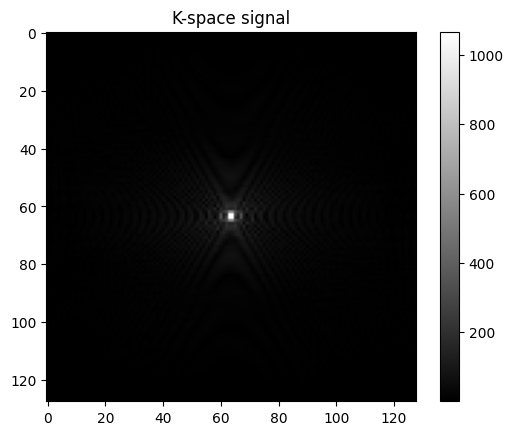

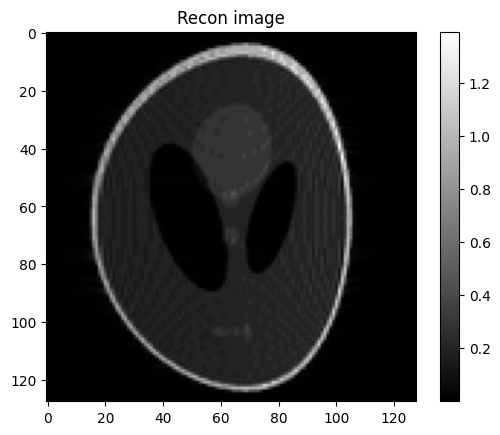

In [2]:
# Time intervals for the gradients
tau = 2e-3 # seconds
time = np.linspace(-tau/2,tau/2,N_spins)

# Gradient fields (assuming same for x and y directions)
Gx_values = time * Gx
Gy_values = time * Gx

# k-space trajectory (assuming same for x and y directions)
kx_values = gamma * Gx_values 
ky_values = gamma * Gy_values

# Define field of view
FOV = .2  # meters
x_values = np.linspace(-FOV / 2, FOV / 2, N_spins)
y_values = np.linspace(-FOV / 2, FOV / 2, N_spins)
x_values, y_values = np.meshgrid(x_values, y_values, indexing='ij')  # Create 2D coordinate grid

# Flatten the phantom
phantom_flat = phantom.flatten()

# Flatten the arrays to make them 1D
x_values_flat = x_values.flatten()
y_values_flat = y_values.flatten()
B0_field_map_flat = B0_using.flatten()

# Allocate memory for flattened k-space
k_space_flat = np.zeros(N_spins**2, dtype=np.complex128)



# Iterate through the kx and ky values
iterator = 0
for i, kx in tqdm(enumerate(kx_values)):
    for j, ky in enumerate(ky_values):
        # Calculate the k-space value for this (kx, ky) point
        k_space_flat[iterator] = np.sum(phantom_flat * np.exp(-1j * (kx * x_values_flat + ky * y_values_flat + B0_field_map_flat * time[j])))
        iterator += 1

# Reshape the flattened k-space data back into 2D matrix form
k_space = np.reshape(k_space_flat, (N_spins, N_spins))

# Plot the absolute k-space signal
plt.figure()
plt.imshow(np.abs(k_space), cmap='gray')
plt.title('K-space signal')
plt.colorbar()
plt.show()

dwll_time = tau/N_spins

readout_bandwidth =  1/dwll_time

# Apply inverse FFT
reconstructed_image = ifft2(k_space)
reconstructed_image_1 = fftshift(reconstructed_image)

# Plot the reconstructed image
plt.figure()
plt.imshow(np.abs(reconstructed_image_1), cmap='gray')
plt.title('Recon image')
plt.colorbar()
plt.show()

In [12]:
# Reshape the k-space data into a vector
E = np.zeros((N_spins**2, N_spins**2), dtype=np.complex128)

iterator = 0
for i, kx in tqdm(enumerate(kx_values)):
    for j, ky in enumerate(ky_values):
        # Use the flattened arrays in the calculation
        E[iterator, :] = np.exp(-1j * (kx * x_values_flat + ky * y_values_flat + B0_field_map_flat * time[j]))
        iterator += 1

128it [00:12,  9.86it/s]


In [13]:
x_1, istop, itn, r1norm, r2norm, anorm, acond, arnorm, xnorm, var = lsqr(E, k_space_flat, iter_lim=200, show=True)
image_1 = np.reshape(x_1, (N_spins, N_spins))

 
LSQR            Least-squares solution of  Ax = b
The matrix A has 16384 rows and 16384 columns
damp = 0.00000000000000e+00   calc_var =        0
atol = 1.00e-06                 conlim = 1.00e+08
btol = 1.00e-06               iter_lim =      200
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   3.765e+03  3.765e+03    1.0e+00  3.4e-02
     1 3.00248e-04-1.00461e-16j   5.127e+02  5.127e+02    1.4e-01  1.1e+00   1.3e+02  1.0e+00
     2 -4.09178e-04-4.05044e-15j   1.292e+02  1.292e+02    3.4e-02  8.3e-01   1.9e+02  2.0e+00
     3 1.74749e-03+5.66814e-15j   7.901e+01  7.901e+01    2.1e-02  9.1e-01   2.8e+02  3.3e+00
     4 9.66815e-04+1.81326e-15j   5.524e+01  5.524e+01    1.5e-02  4.3e-01   4.9e+02  6.2e+00
     5 -8.92508e-04-3.84541e-15j   3.595e+01  3.595e+01    9.6e-03  3.1e-01   6.0e+02  8.0e+00
     6 6.08666e-04+5.55557e-16j   2.301e+01  2.301e+01    6.1e-03  3.1e-01   6.7e+02  9.6e+00
     7 7.04720e-04-9.69970e-16j   1.503e

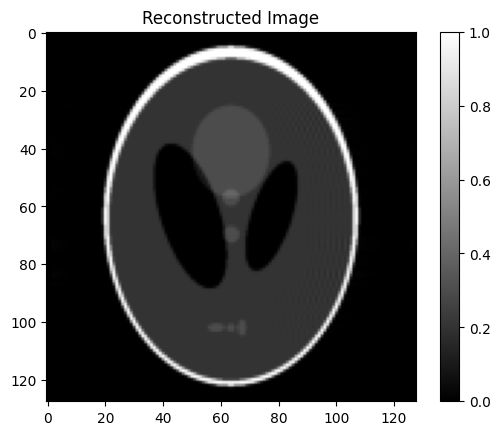

In [14]:
plt.figure()
plt.imshow(np.abs(image_1), cmap='gray', vmin=0, vmax=1.0)
plt.colorbar()
plt.title('Reconstructed Image')
plt.show()

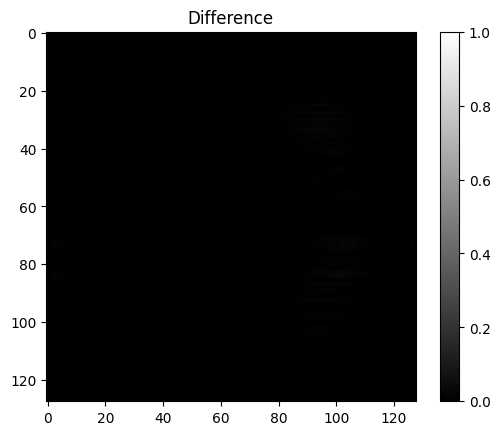

In [15]:
# Make a difference plot of the phantom and the reconstructed image
plt.figure()
plt.imshow(np.abs(phantom - image_1), cmap='gray', vmin=0, vmax=1.0)
plt.colorbar()
plt.title('Difference')
plt.show()

In [16]:
# Finding the average difference between the reconstructed image and the phantom
difference = np.mean(np.abs(phantom - image_1))
difference

0.0010591572666544275